In [1]:
import numpy as np

In [2]:
import json
import shap

In [3]:
from __future__ import print_function
from __future__ import division
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [4]:
model = torch.load("../models/model_resnet_best_val_acc_0.942.pt")

In [5]:
#resnet = models.resnet18(pretrained=True)

In [6]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/datasets" + "/MaskedFace-Net"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

input_size = 224

## ImageNet

In [61]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

In [ ]:
vgg = models.vgg16(pretrained=True).eval()

In [22]:
X,y = shap.datasets.imagenet50()

In [64]:
to_explain = X[[39, 41]]

In [60]:
# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

In [13]:
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

In [ ]:
e = shap.GradientExplainer((vgg, vgg.features[7]), normalize(X))
shap_values,indexes = e.shap_values(normalize(to_explain), ranked_outputs=2, nsamples=200)

## MaskedFace-Net

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [8]:
inputs, labels = iter(dataloaders_dict['train']).next()

In [9]:
inputs.shape

torch.Size([32, 3, 224, 224])

## Method 1

In [14]:
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", inputs[0].shape)

In [15]:
class_names = ['correctly masked', 'incorrectly masked', 'not masked']

In [16]:
# create an explainer with model and image masker
explainer = shap.Explainer(model, masker, output_names=class_names)

explainers.Partition is still in an alpha state, so use with caution...


In [17]:
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(inputs[1:3].reshape(2, 224, 224, 3), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

AttributeError: 'Tensor' object has no attribute 'copy'

In [23]:
inputs[1:3].shape

torch.Size([2, 3, 224, 224])

In [24]:
X[1:3].shape

(2, 224, 224, 3)

## Method 2

In [10]:
background = inputs[:22]
test_inputs = inputs[22:32]

In [11]:
test_inputs.shape

torch.Size([10, 3, 64, 64])

In [36]:
e = shap.GradientExplainer((model, model.features[7]), normalize(X))

In [56]:
shap_values = e.shap_values(test_inputs)

In [50]:
np.swapaxes(np.swapaxes(shap_values[0], 1, -1), 1, 2).shape

(3, 3, 64, 64, 10)

In [51]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values[:1]]
test_numpy = np.swapaxes(np.swapaxes(test_inputs.numpy(), 1, -1), 1, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

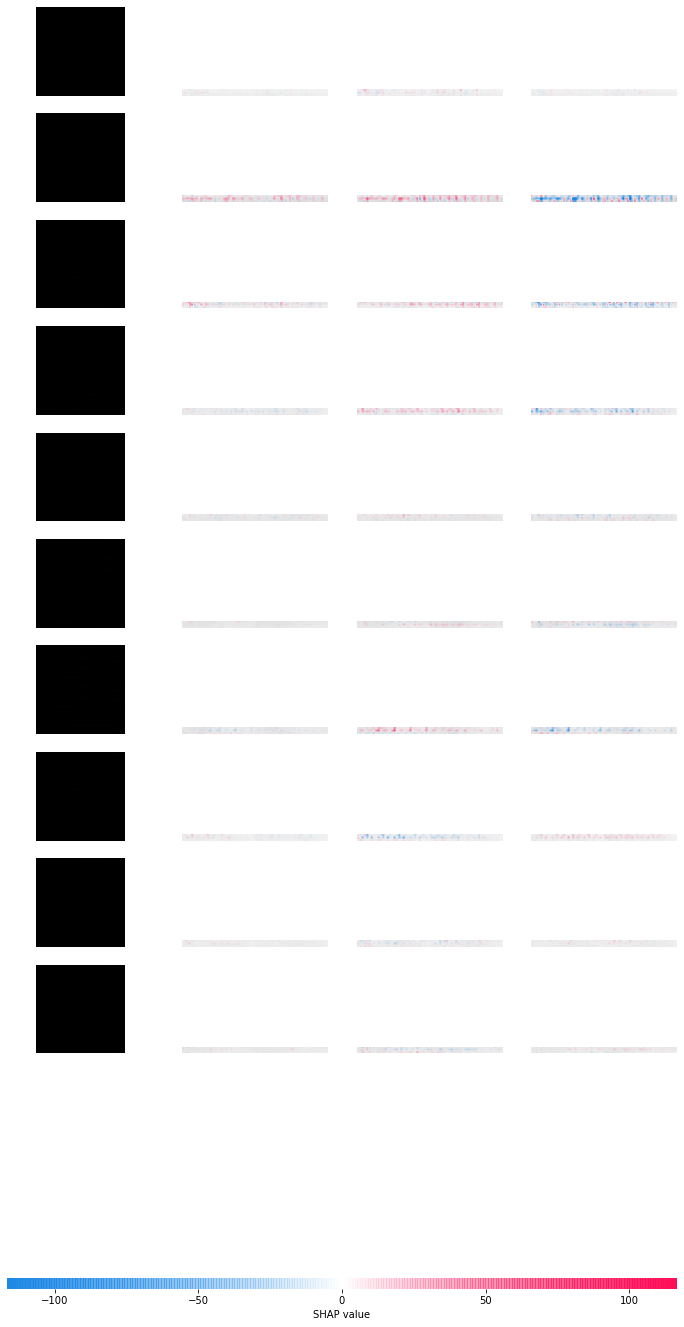

In [55]:
shap.image_plot(shap_values[0], -test_numpy)
